In [1]:
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from antea.io.mc_io import load_mcsns_response
from antea.io.mc_io import load_sns_positions
from antea.io.mc_io import load_mcparticles
from antea.io.mc_io import load_mchits

import antea.reco.reco_functions as rf

### hdf5 files analysis

In [2]:
filepath = '/Users/carmenromoluque/nexus_petit_analysis/tof_setup/PetBox_analysis/data_h5/'
filename = filepath + 'PetBox_asymmetric_tile5centered_HamamatsuVUV.000.pet.h5'

## Extract the information from the tables in the file
sns_response  = load_mcsns_response(filename)
sns_positions = load_sns_positions (filename)
mcparticles   = load_mcparticles   (filename)
mchits        = load_mchits        (filename)

DataSiPM     = sns_positions.rename(columns={"sensor_id": "SensorID","x": "X", "y": "Y", "z": "Z"})
DataSiPM_idx = DataSiPM.set_index('SensorID')

In [3]:
sns_response.head(3)

,event_id,sensor_id,time_bin,charge
0,0,124,0,67
1,0,111,0,57
2,0,131,0,80


In [4]:
sns_positions.head(3)

,sensor_id,sensor_name,x,y,z
0,124,SiPMHmtsuVUV,-11.25,3.75,55.404999
1,111,SiPMHmtsuVUV,11.25,11.25,55.404999
2,131,SiPMHmtsuVUV,11.25,-3.75,55.404999


In [5]:
mcparticles.head(3)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,0,7,e-,0,3,0.435498,-2.096558,35.240894,0.117768,0.435497,...,-0.004653,0.000030,0.003506,0.0,-0.0,0.0,0.000033,0.000002,compt,Scintillation
1,0,6,e-,0,3,0.435498,-2.096558,35.240894,0.117768,0.435498,...,-0.002313,-0.003760,0.005298,-0.0,0.0,-0.0,0.000047,0.000001,compt,Scintillation
2,0,5,e-,0,3,0.435498,-2.096558,35.240894,0.117768,0.435497,...,-0.002464,-0.004137,-0.000626,0.0,-0.0,-0.0,0.000023,0.000003,compt,Scintillation


In [6]:
mchits.head(3)

,event_id,x,y,z,time,energy,label,particle_id
0,0,0.435498,-2.096558,35.240894,0.117768,0.000058,ACTIVE,3
1,0,0.435497,-2.096558,35.240894,0.117768,0.000033,ACTIVE,7
2,0,0.435498,-2.096559,35.240894,0.117768,0.000047,ACTIVE,6


### Sensor position:

In [7]:
sorted_sns = sns_positions.sort_values(by=['sensor_id'])

init_id  = [0, 4, 40, 44, 100]
sensors1 = np.array([11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 41, 42, 43, 44])
all_ids  = np.array([sensors1+i for i in init_id])

tile1 = sorted_sns[sorted_sns.sensor_id.isin(all_ids[0])]
tile2 = sorted_sns[sorted_sns.sensor_id.isin(all_ids[1])]
tile3 = sorted_sns[sorted_sns.sensor_id.isin(all_ids[2])]
tile4 = sorted_sns[sorted_sns.sensor_id.isin(all_ids[3])]
tile5 = sorted_sns[sorted_sns.sensor_id.isin(all_ids[4])]

tiles  = [tile1, tile2, tile3, tile4, tile5]
colors = ['b', 'r', 'g', 'k', 'orange']

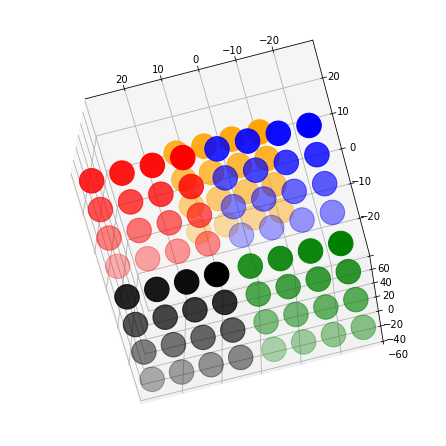

In [8]:
#%matplotlib notebook

fig = plt.figure(figsize=(6,6))
ax  = Axes3D(fig)
for tile, col in zip(tiles, colors):
    ax.scatter(tile.x.values, tile.y.values, tile.z.values, marker='o', s=600, color=col)
ax.view_init(-70, 105)

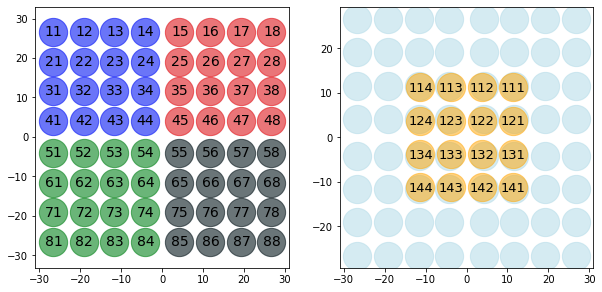

In [9]:
## Hamamatsu numeration after convention

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.8))
ax1.scatter(sorted_sns[sorted_sns.z<0].x, 
            sorted_sns[sorted_sns.z<0].y, 
            marker='o', s=800, color='lightblue', alpha=0.5)
for tile, col in zip(tiles[:4], colors):
    ax1.scatter(tile.x.values, tile.y.values, marker='o', s=800, color=col, alpha=0.5)
    for i, (x, y) in enumerate(zip(tile.x.values, tile.y.values)):
        ax1.text(x-2, y-1, s=str(tile.sensor_id.values[i]), fontsize=14)
ax1.set_xlim(-31,31)

ax2.scatter(sorted_sns[sorted_sns.z<0].x, 
            sorted_sns[sorted_sns.z<0].y, 
            marker='o', s=800, color='lightblue', alpha=0.5)
ax2.scatter(tiles[4].x.values, tiles[4].y.values, marker='o', s=800, color=colors[4], alpha=0.5)
for i, (x, y) in enumerate(zip(tiles[4].x.values, tiles[4].y.values)):
    ax2.text(x-3, y-1, s=str(tiles[4].sensor_id.values[i]), fontsize=13)
ax2.set_xlim(-31,31)

plt.show()

### Analysis of the tables

In [10]:
## Detector plane: plane with the four tiles (neg z)
## Coincidence plane: plane with the fifth tile (pos z)

def info_from_the_tiles(DataSiPM_idx, evt_sns):
    sipms       = DataSiPM_idx.loc[evt_sns.sensor_id]
    sns_ids     = sipms.index.astype('int64').values
    sns_pos     = np.array([sipms.X.values, sipms.Y.values, sipms.Z.values]).transpose()
    sns_charges = evt_sns.charge.values
    sel = sipms.Z.values<0
    return (sns_ids[ sel], sns_pos[ sel], sns_charges[ sel], #Plane with 4 tiles
            sns_ids[~sel], sns_pos[~sel], sns_charges[~sel]) #Plane with 1 tile

def axis_params(fig0, ax0, plane):
    ax0.set_xlabel("X (mm)",      fontsize=12)
    ax0.set_ylabel("Y (mm)",      fontsize=12)
    ax0.set_title(f"{plane} plane", fontsize=12)
    ax0.set_xlim(-31, 31)
    ax0.set_ylim(-31, 31)
    fig.colorbar(fig0, ax=ax0, label='Charges')

#### Plot one event:

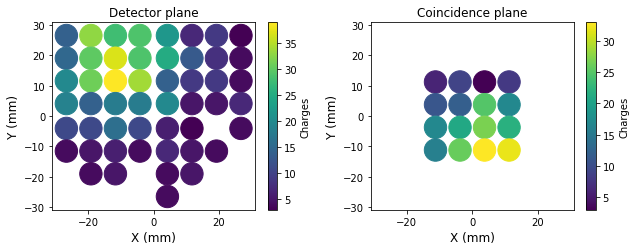

In [16]:
threshold = 2 #threshold in the charge

events  = mcparticles.event_id.unique()
evt     = events[21] # Beautiful event
evt_sns = sns_response[sns_response.event_id == evt]
evt_sns = rf.find_SiPMs_over_threshold(evt_sns, threshold=threshold)

ids1, pos1, qs1, ids2, pos2, qs2 = info_from_the_tiles(DataSiPM_idx, evt_sns)

pos1_x = pos1.T[0]
pos1_y = pos1.T[1]

pos2_x = pos2.T[0]
pos2_y = pos2.T[1]

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(9, 3.6))
fig0 = ax0.scatter(pos1_x, pos1_y, c=qs1, s=500)
fig1 = ax1.scatter(pos2_x, pos2_y, c=qs2, s=500)
axis_params(fig0, ax0, 'Detector')
axis_params(fig1, ax1, 'Coincidence')
plt.tight_layout()
plt.show()

### Charge

In [17]:
threshold   = 2 #threshold in the charge
tot_charges = []

## Loop over the events
events = mcparticles.event_id.unique()
for evt in events:
    evt_sns = sns_response[sns_response.event_id == evt]
    evt_sns = rf.find_SiPMs_over_threshold(evt_sns, threshold=threshold)
    
    ids, pos, qs, _, _, _ = info_from_the_tiles(DataSiPM_idx, evt_sns)    
    tot_charges.append(sum(qs))

tot_charges = np.array(tot_charges)

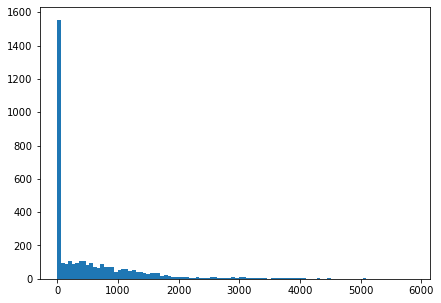

In [18]:
fig = plt.figure(figsize=(7,5))
plt.hist(tot_charges, 100);

### Charge selecting the central area for the sensor with max charge

In [19]:
ch_max_central_area = []
central_area_ids    = [33, 34, 35, 36, 43, 44, 45, 46, 53, 54, 55, 56, 63, 64, 65, 66]

events = mcparticles.event_id.unique()
for evt in events:
    evt_sns = sns_response[sns_response.event_id == evt]
    evt_sns = rf.find_SiPMs_over_threshold(evt_sns, threshold=threshold)
    
    ids, pos, qs, _, _, _ = info_from_the_tiles(DataSiPM_idx, evt_sns)
    if len(qs)==0:
        continue
    max_charge_s_id = ids[np.argmax(qs)]
    if max_charge_s_id in central_area_ids:
        ch_max_central_area.append(sum(qs))

ch_max_central_area = np.array(ch_max_central_area)

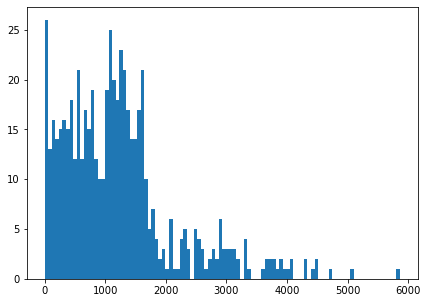

In [20]:
fig = plt.figure(figsize=(7,5))
plt.hist(ch_max_central_area, 100);